In [1]:
import colorsys
import logging
import math
import numpy as np
from enum import Enum, unique
import cv2
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import pycocotools.mask as mask_util
import torch
from matplotlib.backends.backend_agg import FigureCanvasAgg

from detectron2.structures import BitMasks, Boxes, BoxMode, Keypoints, PolygonMasks, RotatedBoxes


logger = logging.getLogger(__name__)

__all__ = ["ColorMode", "VisImage", "Visualizer"]


_SMALL_OBJECT_AREA_THRESH = 1000
_LARGE_MASK_AREA_THRESH = 120000
_OFF_WHITE = (1.0, 1.0, 240.0 / 255)
_BLACK = (0, 0, 0)
_RED = (1.0, 0, 0)

_KEYPOINT_THRESHOLD = 0.05


@unique
class ColorMode(Enum):
    """
    Enum of different color modes to use for instance visualizations.

    Attributes:
        IMAGE: Picks a random color for every instance and overlay segmentations with low opacity.
        SEGMENTATION: Let instances of the same category have similar colors
            (from metadata.thing_colors), and overlay them with
            high opacity. This provides more attention on the quality of segmentation.
        IMAGE_BW: same as IMAGE, but convert all areas without masks to gray-scale.
            Only available for drawing per-instance mask predictions.
    """

    IMAGE = 0
    SEGMENTATION = 1
    IMAGE_BW = 2


class GenericMask:
    """
    Attribute:
        polygons (list[ndarray]): list[ndarray]: polygons for this mask.
            Each ndarray has format [x, y, x, y, ...]
        mask (ndarray): a binary mask
    """

    def __init__(self, mask_or_polygons, height, width):
        self._mask = self._polygons = self._has_holes = None
        self.height = height
        self.width = width

        m = mask_or_polygons
        if isinstance(m, dict):
            # RLEs
            assert "counts" in m and "size" in m
            if isinstance(m["counts"], list):  # uncompressed RLEs
                h, w = m["size"]
                assert h == height and w == width
                m = mask_util.frPyObjects(m, h, w)
            self._mask = mask_util.decode(m)[:, :]
            return

        if isinstance(m, list):  # list[ndarray]
            self._polygons = [np.asarray(x).reshape(-1) for x in m]
            return

        if isinstance(m, np.ndarray):  # assumed to be a binary mask
            assert m.shape[1] != 2, m.shape
            assert m.shape == (height, width), m.shape
            self._mask = m.astype("uint8")
            return

        raise ValueError("GenericMask cannot handle object {} of type '{}'".format(m, type(m)))

    @property
    def mask(self):
        if self._mask is None:
            self._mask = self.polygons_to_mask(self._polygons)
        return self._mask

    @property
    def polygons(self):
        if self._polygons is None:
            self._polygons, self._has_holes = self.mask_to_polygons(self._mask)
        return self._polygons

    @property
    def has_holes(self):
        if self._has_holes is None:
            if self._mask is not None:
                self._polygons, self._has_holes = self.mask_to_polygons(self._mask)
            else:
                self._has_holes = False  # if original format is polygon, does not have holes
        return self._has_holes

    def mask_to_polygons(self, mask):
        # cv2.RETR_CCOMP flag retrieves all the contours and arranges them to a 2-level
        # hierarchy. External contours (boundary) of the object are placed in hierarchy-1.
        # Internal contours (holes) are placed in hierarchy-2.
        # cv2.CHAIN_APPROX_NONE flag gets vertices of polygons from contours.
        mask = np.ascontiguousarray(mask)  # some versions of cv2 does not support incontiguous arr
        res = cv2.findContours(mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        hierarchy = res[-1]
        if hierarchy is None:  # empty mask
            return [], False
        has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
        res = res[-2]
        res = [x.flatten() for x in res]
        res = [x for x in res if len(x) >= 6]
        return res, has_holes

    def polygons_to_mask(self, polygons):
        rle = mask_util.frPyObjects(polygons, self.height, self.width)
        rle = mask_util.merge(rle)
        return mask_util.decode(rle)[:, :]

    def area(self):
        return self.mask.sum()

    def bbox(self):
        p = mask_util.frPyObjects(self.polygons, self.height, self.width)
        p = mask_util.merge(p)
        bbox = mask_util.toBbox(p)
        bbox[2] += bbox[0]
        bbox[3] += bbox[1]
        return bbox


class _PanopticPrediction:
    def __init__(self, panoptic_seg, segments_info):
        self._seg = panoptic_seg

        self._sinfo = {s["id"]: s for s in segments_info}  # seg id -> seg info
        segment_ids, areas = torch.unique(panoptic_seg, sorted=True, return_counts=True)
        areas = areas.numpy()
        sorted_idxs = np.argsort(-areas)
        self._seg_ids, self._seg_areas = segment_ids[sorted_idxs], areas[sorted_idxs]
        self._seg_ids = self._seg_ids.tolist()
        for sid, area in zip(self._seg_ids, self._seg_areas):
            if sid in self._sinfo:
                self._sinfo[sid]["area"] = float(area)

    def non_empty_mask(self):
        """
        Returns:
            (H, W) array, a mask for all pixels that have a prediction
        """
        empty_ids = []
        for id in self._seg_ids:
            if id not in self._sinfo:
                empty_ids.append(id)
        if len(empty_ids) == 0:
            return np.zeros(self._seg.shape, dtype=np.uint8)
        assert (
            len(empty_ids) == 1
        ), ">1 ids corresponds to no labels. This is currently not supported"
        return (self._seg != empty_ids[0]).numpy().astype(np.bool)

    def semantic_masks(self):
        for sid in self._seg_ids:
            sinfo = self._sinfo.get(sid)
            if sinfo is None or sinfo["isthing"]:
                # Some pixels (e.g. id 0 in PanopticFPN) have no instance or semantic predictions.
                continue
            yield (self._seg == sid).numpy().astype(np.bool), sinfo

    def instance_masks(self):
        for sid in self._seg_ids:
            sinfo = self._sinfo.get(sid)
            if sinfo is None or not sinfo["isthing"]:
                continue
            mask = (self._seg == sid).numpy().astype(np.bool)
            if mask.sum() > 0:
                yield mask, sinfo


def _create_text_labels(classes, scores, class_names):
    """
    Args:
        classes (list[int] or None):
        scores (list[float] or None):
        class_names (list[str] or None):

    Returns:
        list[str] or None
    """
    labels = None
    if classes is not None and class_names is not None and len(class_names) > 1:
        labels = [class_names[i] for i in classes]
    if scores is not None:
        if labels is None:
            labels = ["{:.0f}%".format(s * 100) for s in scores]
        else:
            labels = ["{} {:.0f}%".format(l, s * 100) for l, s in zip(labels, scores)]
    return labels


class VisImage:
    def __init__(self, img, scale=1.0):
        """
        Args:
            img (ndarray): an RGB image of shape (H, W, 3).
            scale (float): scale the input image
        """
        self.img = img
        self.scale = scale
        self.width, self.height = img.shape[1], img.shape[0]
        self._setup_figure(img)

    def _setup_figure(self, img):
        """
        Args:
            Same as in :meth:`__init__()`.

        Returns:
            fig (matplotlib.pyplot.figure): top level container for all the image plot elements.
            ax (matplotlib.pyplot.Axes): contains figure elements and sets the coordinate system.
        """
        fig = mplfigure.Figure(frameon=False)
        self.dpi = fig.get_dpi()
        # add a small 1e-2 to avoid precision lost due to matplotlib's truncation
        # (https://github.com/matplotlib/matplotlib/issues/15363)
        fig.set_size_inches(
            (self.width * self.scale + 1e-2) / self.dpi,
            (self.height * self.scale + 1e-2) / self.dpi,
        )
        self.canvas = FigureCanvasAgg(fig)
        # self.canvas = mpl.backends.backend_cairo.FigureCanvasCairo(fig)
        ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
        ax.axis("off")
        ax.set_xlim(0.0, self.width)
        ax.set_ylim(self.height)

        self.fig = fig
        self.ax = ax

    def save(self, filepath):
        """
        Args:
            filepath (str): a string that contains the absolute path, including the file name, where
                the visualized image will be saved.
        """
        if filepath.lower().endswith(".jpg") or filepath.lower().endswith(".png"):
            # faster than matplotlib's imshow
            cv2.imwrite(filepath, self.get_image()[:, :, ::-1])
        else:
            # support general formats (e.g. pdf)
            self.ax.imshow(self.img, interpolation="nearest")
            self.fig.savefig(filepath)

    def get_image(self):
        """
        Returns:
            ndarray: the visualized image of shape (H, W, 3) (RGB) in uint8 type.
              The shape is scaled w.r.t the input image using the given `scale` argument.
        """
        canvas = self.canvas
        s, (width, height) = canvas.print_to_buffer()
        if (self.width, self.height) != (width, height):
            img = cv2.resize(self.img, (width, height))
        else:
            img = self.img

        # buf = io.BytesIO()  # works for cairo backend
        # canvas.print_rgba(buf)
        # width, height = self.width, self.height
        # s = buf.getvalue()

        buffer = np.frombuffer(s, dtype="uint8")

        # imshow is slow. blend manually (still quite slow)
        img_rgba = buffer.reshape(height, width, 4)
        rgb, alpha = np.split(img_rgba, [3], axis=2)

        try:
            import numexpr as ne  # fuse them with numexpr

            visualized_image = ne.evaluate("img * (1 - alpha / 255.0) + rgb * (alpha / 255.0)")
        except ImportError:
            alpha = alpha.astype("float32") / 255.0
            visualized_image = img * (1 - alpha) + rgb * alpha

        visualized_image = visualized_image.astype("uint8")

        return visualized_image


class Visualizer:
    def __init__(self, img_rgb, metadata, scale=1.0, instance_mode=ColorMode.IMAGE):
        """
        Args:
            img_rgb: a numpy array of shape (H, W, C), where H and W correspond to
                the height and width of the image respectively. C is the number of
                color channels. The image is required to be in RGB format since that
                is a requirement of the Matplotlib library. The image is also expected
                to be in the range [0, 255].
            metadata (MetadataCatalog): image metadata.
        """
        self.img = np.asarray(img_rgb).clip(0, 255).astype(np.uint8)
        self.metadata = metadata
        self.output = VisImage(self.img, scale=scale)
        self.cpu_device = torch.device("cpu")

        # too small texts are useless, therefore clamp to 9
        self._default_font_size = max(
            np.sqrt(self.output.height * self.output.width) // 90, 10 // scale
        )
        self._instance_mode = instance_mode

    def draw_instance_predictions(self, predictions):
        """
        Draw instance-level prediction results on an image.

        Args:
            predictions (Instances): the output of an instance detection/segmentation
                model. Following fields will be used to draw:
                "pred_boxes", "pred_classes", "scores", "pred_masks" (or "pred_masks_rle").

        Returns:
            output (VisImage): image object with visualizations.
        """
        boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes if predictions.has("pred_classes") else None
        labels = _create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

        if predictions.has("pred_masks"):
            masks = np.asarray(predictions.pred_masks)
            masks = [GenericMask(x, self.output.height, self.output.width) for x in masks]
        else:
            masks = None

        if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
            colors = [
                [x / 255 for x in self.metadata.thing_colors[c]] for c in classes
            ]
            alpha = 0.8
        else:
            colors = None
            alpha = 0.5

        if self._instance_mode == ColorMode.IMAGE_BW:
            assert predictions.has("pred_masks"), "ColorMode.IMAGE_BW requires segmentations"
            self.output.img = self._create_grayscale_image(
                (predictions.pred_masks.any(dim=0) > 0).numpy()
            )
            alpha = 0.3

        self.overlay_instances(
            masks=masks,
            boxes=boxes,
            labels=labels,
            keypoints=keypoints,
            assigned_colors=colors,
            alpha=alpha,
        )
        return self.output

    def draw_sem_seg(self, sem_seg, area_threshold=None, alpha=0.8):
        """
        Draw semantic segmentation predictions/labels.

        Args:
            sem_seg (Tensor or ndarray): the segmentation of shape (H, W).
            area_threshold (int): segments with less than `area_threshold` are not drawn.
            alpha (float): the larger it is, the more opaque the segmentations are.

        Returns:
            output (VisImage): image object with visualizations.
        """
        if isinstance(sem_seg, torch.Tensor):
            sem_seg = sem_seg.numpy()
        labels, areas = np.unique(sem_seg, return_counts=True)
        sorted_idxs = np.argsort(-areas).tolist()
        labels = labels[sorted_idxs]
        for label in filter(lambda l: l < len(self.metadata.stuff_classes), labels):
            try:
                mask_color = [x / 255 for x in self.metadata.stuff_colors[label]]
            except (AttributeError, IndexError):
                mask_color = None

            binary_mask = (sem_seg == label).astype(np.uint8)
            text = self.metadata.stuff_classes[label]
            self.draw_binary_mask(
                binary_mask,
                color=mask_color,
                edge_color=_OFF_WHITE,
                text=text,
                alpha=alpha,
                area_threshold=area_threshold,
            )
        return self.output

    def draw_panoptic_seg_predictions(
        self, panoptic_seg, segments_info, area_threshold=None, alpha=0.7
    ):
        """
        Draw panoptic prediction results on an image.

        Args:
            panoptic_seg (Tensor): of shape (height, width) where the values are ids for each
                segment.
            segments_info (list[dict]): Describe each segment in `panoptic_seg`.
                Each dict contains keys "id", "category_id", "isthing".
            area_threshold (int): stuff segments with less than `area_threshold` are not drawn.

        Returns:
            output (VisImage): image object with visualizations.
        """
        pred = _PanopticPrediction(panoptic_seg, segments_info)

        if self._instance_mode == ColorMode.IMAGE_BW:
            self.output.img = self._create_grayscale_image(pred.non_empty_mask())

        # draw mask for all semantic segments first i.e. "stuff"
        for mask, sinfo in pred.semantic_masks():
            category_idx = sinfo["category_id"]
            try:
                mask_color = [x / 255 for x in self.metadata.stuff_colors[category_idx]]
            except AttributeError:
                mask_color = None

            text = self.metadata.stuff_classes[category_idx]
            self.draw_binary_mask(
                mask,
                color=mask_color,
                edge_color=_OFF_WHITE,
                text=text,
                alpha=alpha,
                area_threshold=area_threshold,
            )

        # draw mask for all instances second
        all_instances = list(pred.instance_masks())
        if len(all_instances) == 0:
            return self.output
        masks, sinfo = list(zip(*all_instances))
        category_ids = [x["category_id"] for x in sinfo]

        try:
            scores = [x["score"] for x in sinfo]
        except KeyError:
            scores = None
        labels = _create_text_labels(category_ids, scores, self.metadata.thing_classes)

        try:
            colors = [random_color(rgb=True, maximum=1) for k in category_ids]
        except AttributeError:
            colors = None
        self.overlay_instances(masks=masks, labels=labels, assigned_colors=colors, alpha=alpha)

        return self.output

    def draw_dataset_dict(self, dic):
        """
        Draw annotations/segmentaions in Detectron2 Dataset format.

        Args:
            dic (dict): annotation/segmentation data of one image, in Detectron2 Dataset format.

        Returns:
            output (VisImage): image object with visualizations.
        """
        annos = dic.get("annotations", None)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None

            boxes = [BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYXY_ABS) for x in annos]

            labels = [x["category_id"] for x in annos]
            colors = None
            if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
                colors = [
                    self._jitter([x / 255 for x in self.metadata.thing_colors[c]]) for c in labels
                ]
            names = self.metadata.get("thing_classes", None)
            if names:
                labels = [names[i] for i in labels]
            labels = [
                "{}".format(i) + ("|crowd" if a.get("iscrowd", 0) else "")
                for i, a in zip(labels, annos)
            ]
            self.overlay_instances(
                labels=labels, boxes=boxes, masks=masks, keypoints=keypts, assigned_colors=colors
            )

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            sem_seg = cv2.imread(dic["sem_seg_file_name"], cv2.IMREAD_GRAYSCALE)
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)
        return self.output

    def overlay_instances(
        self,
        *,
        boxes=None,
        labels=None,
        masks=None,
        keypoints=None,
        assigned_colors=None,
        alpha=0.5
    ):
        """
        Args:
            boxes (Boxes, RotatedBoxes or ndarray): either a :class:`Boxes`,
                or an Nx4 numpy array of XYXY_ABS format for the N objects in a single image,
                or a :class:`RotatedBoxes`,
                or an Nx5 numpy array of (x_center, y_center, width, height, angle_degrees) format
                for the N objects in a single image,
            labels (list[str]): the text to be displayed for each instance.
            masks (masks-like object): Supported types are:

                * `structures.masks.PolygonMasks`, `structures.masks.BitMasks`.
                * list[list[ndarray]]: contains the segmentation masks for all objects in one image.
                    The first level of the list corresponds to individual instances. The second
                    level to all the polygon that compose the instance, and the third level
                    to the polygon coordinates. The third level should have the format of
                    [x0, y0, x1, y1, ..., xn, yn] (n >= 3).
                * list[ndarray]: each ndarray is a binary mask of shape (H, W).
                * list[dict]: each dict is a COCO-style RLE.
            keypoints (Keypoint or array like): an array-like object of shape (N, K, 3),
                where the N is the number of instances and K is the number of keypoints.
                The last dimension corresponds to (x, y, visibility or score).
            assigned_colors (list[matplotlib.colors]): a list of colors, where each color
                corresponds to each mask or box in the image. Refer to 'matplotlib.colors'
                for full list of formats that the colors are accepted in.

        Returns:
            output (VisImage): image object with visualizations.
        """
        num_instances = None
        if boxes is not None:
            boxes = self._convert_boxes(boxes)
            num_instances = len(boxes)
        if masks is not None:
            masks = self._convert_masks(masks)
            if num_instances:
                assert len(masks) == num_instances
            else:
                num_instances = len(masks)
        if keypoints is not None:
            if num_instances:
                assert len(keypoints) == num_instances
            else:
                num_instances = len(keypoints)
            keypoints = self._convert_keypoints(keypoints)
        if labels is not None:
            assert len(labels) == num_instances
        if assigned_colors is None:
            assigned_colors = [random_color(rgb=True, maximum=1) for _ in range(num_instances)]
        if num_instances == 0:
            return self.output
        if boxes is not None and boxes.shape[1] == 5:
            return self.overlay_rotated_instances(
                boxes=boxes, labels=labels, assigned_colors=assigned_colors
            )

        # Display in largest to smallest order to reduce occlusion.
        areas = None
        if boxes is not None:
            areas = np.prod(boxes[:, 2:] - boxes[:, :2], axis=1)
        elif masks is not None:
            areas = np.asarray([x.area() for x in masks])

        if areas is not None:
            sorted_idxs = np.argsort(-areas).tolist()
            # Re-order overlapped instances in descending order.
            boxes = boxes[sorted_idxs] if boxes is not None else None
            labels = [labels[k] for k in sorted_idxs] if labels is not None else None
            masks = [masks[idx] for idx in sorted_idxs] if masks is not None else None
            assigned_colors = [assigned_colors[idx] for idx in sorted_idxs]
            keypoints = keypoints[sorted_idxs] if keypoints is not None else None

        for i in range(num_instances):
            color = assigned_colors[i]
            if boxes is not None:
                self.draw_box(boxes[i], edge_color=color)

            if masks is not None:
                for segment in masks[i].polygons:
                    self.draw_polygon(segment.reshape(-1, 2), color, alpha=alpha)

            if labels is not None:
                # first get a box
                if boxes is not None:
                    x0, y0, x1, y1 = boxes[i]
                    text_pos = (x0, y0)  # if drawing boxes, put text on the box corner.
                    horiz_align = "left"
                elif masks is not None:
                    x0, y0, x1, y1 = masks[i].bbox()

                    # draw text in the center (defined by median) when box is not drawn
                    # median is less sensitive to outliers.
                    text_pos = np.median(masks[i].mask.nonzero(), axis=1)[::-1]
                    horiz_align = "center"
                else:
                    continue  # drawing the box confidence for keypoints isn't very useful.
                # for small objects, draw text at the side to avoid occlusion
                instance_area = (y1 - y0) * (x1 - x0)
                if (
                    instance_area < _SMALL_OBJECT_AREA_THRESH * self.output.scale
                    or y1 - y0 < 40 * self.output.scale
                ):
                    if y1 >= self.output.height - 5:
                        text_pos = (x1, y0)
                    else:
                        text_pos = (x0, y1)

                height_ratio = (y1 - y0) / np.sqrt(self.output.height * self.output.width)
                lighter_color = self._change_color_brightness(color, brightness_factor=0.7)
                font_size = (
                    np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2)
                    * 0.5
                    * self._default_font_size
                )
                self.draw_text(
                    labels[i],
                    text_pos,
                    color=lighter_color,
                    horizontal_alignment=horiz_align,
                    font_size=font_size,
                )

        # draw keypoints
        if keypoints is not None:
            for keypoints_per_instance in keypoints:
                self.draw_and_connect_keypoints(keypoints_per_instance)

        return self.output

    def overlay_rotated_instances(self, boxes=None, labels=None, assigned_colors=None):
        """
        Args:
            boxes (ndarray): an Nx5 numpy array of
                (x_center, y_center, width, height, angle_degrees) format
                for the N objects in a single image.
            labels (list[str]): the text to be displayed for each instance.
            assigned_colors (list[matplotlib.colors]): a list of colors, where each color
                corresponds to each mask or box in the image. Refer to 'matplotlib.colors'
                for full list of formats that the colors are accepted in.

        Returns:
            output (VisImage): image object with visualizations.
        """

        num_instances = len(boxes)

        if assigned_colors is None:
            assigned_colors = [random_color(rgb=True, maximum=1) for _ in range(num_instances)]
        if num_instances == 0:
            return self.output

        # Display in largest to smallest order to reduce occlusion.
        if boxes is not None:
            areas = boxes[:, 2] * boxes[:, 3]

        sorted_idxs = np.argsort(-areas).tolist()
        # Re-order overlapped instances in descending order.
        boxes = boxes[sorted_idxs]
        labels = [labels[k] for k in sorted_idxs] if labels is not None else None
        colors = [assigned_colors[idx] for idx in sorted_idxs]

        for i in range(num_instances):
            self.draw_rotated_box_with_label(
                boxes[i], edge_color=colors[i], label=labels[i] if labels is not None else None
            )

        return self.output

    def draw_and_connect_keypoints(self, keypoints):
        """
        Draws keypoints of an instance and follows the rules for keypoint connections
        to draw lines between appropriate keypoints. This follows color heuristics for
        line color.

        Args:
            keypoints (Tensor): a tensor of shape (K, 3), where K is the number of keypoints
                and the last dimension corresponds to (x, y, probability).

        Returns:
            output (VisImage): image object with visualizations.
        """
        visible = {}
        keypoint_names = self.metadata.get("keypoint_names")
        for idx, keypoint in enumerate(keypoints):
            # draw keypoint
            x, y, prob = keypoint
            if prob > _KEYPOINT_THRESHOLD:
                self.draw_circle((x, y), color=_RED)
                if keypoint_names:
                    keypoint_name = keypoint_names[idx]
                    visible[keypoint_name] = (x, y)

        if self.metadata.get("keypoint_connection_rules"):
            for kp0, kp1, color in self.metadata.keypoint_connection_rules:
                if kp0 in visible and kp1 in visible:
                    x0, y0 = visible[kp0]
                    x1, y1 = visible[kp1]
                    color = tuple(x / 255.0 for x in color)
                    self.draw_line([x0, x1], [y0, y1], color=color)

        # draw lines from nose to mid-shoulder and mid-shoulder to mid-hip
        # Note that this strategy is specific to person keypoints.
        # For other keypoints, it should just do nothing
        try:
            ls_x, ls_y = visible["left_shoulder"]
            rs_x, rs_y = visible["right_shoulder"]
            mid_shoulder_x, mid_shoulder_y = (ls_x + rs_x) / 2, (ls_y + rs_y) / 2
        except KeyError:
            pass
        else:
            # draw line from nose to mid-shoulder
            nose_x, nose_y = visible.get("nose", (None, None))
            if nose_x is not None:
                self.draw_line([nose_x, mid_shoulder_x], [nose_y, mid_shoulder_y], color=_RED)

            try:
                # draw line from mid-shoulder to mid-hip
                lh_x, lh_y = visible["left_hip"]
                rh_x, rh_y = visible["right_hip"]
            except KeyError:
                pass
            else:
                mid_hip_x, mid_hip_y = (lh_x + rh_x) / 2, (lh_y + rh_y) / 2
                self.draw_line([mid_hip_x, mid_shoulder_x], [mid_hip_y, mid_shoulder_y], color=_RED)
        return self.output

    """
    Primitive drawing functions:
    """

    def draw_text(
        self,
        text,
        position,
        *,
        font_size=None,
        color="g",
        horizontal_alignment="center",
        rotation=0
    ):
        """
        Args:
            text (str): class label
            position (tuple): a tuple of the x and y coordinates to place text on image.
            font_size (int, optional): font of the text. If not provided, a font size
                proportional to the image width is calculated and used.
            color: color of the text. Refer to `matplotlib.colors` for full list
                of formats that are accepted.
            horizontal_alignment (str): see `matplotlib.text.Text`
            rotation: rotation angle in degrees CCW

        Returns:
            output (VisImage): image object with text drawn.
        """
        if not font_size:
            font_size = self._default_font_size

        # since the text background is dark, we don't want the text to be dark
        color = np.maximum(list(mplc.to_rgb(color)), 0.2)
        color[np.argmax(color)] = max(0.8, np.max(color))

        x, y = position
        self.output.ax.text(
            x,
            y,
            text,
            size=font_size * self.output.scale,
            family="sans-serif",
            bbox={"facecolor": "black", "alpha": 0.8, "pad": 0.7, "edgecolor": "none"},
            verticalalignment="top",
            horizontalalignment=horizontal_alignment,
            color=color,
            zorder=10,
            rotation=rotation,
        )
        return self.output

    def draw_box(self, box_coord, alpha=0.5, edge_color="g", line_style="-"):
        """
        Args:
            box_coord (tuple): a tuple containing x0, y0, x1, y1 coordinates, where x0 and y0
                are the coordinates of the image's top left corner. x1 and y1 are the
                coordinates of the image's bottom right corner.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
            edge_color: color of the outline of the box. Refer to `matplotlib.colors`
                for full list of formats that are accepted.
            line_style (string): the string to use to create the outline of the boxes.

        Returns:
            output (VisImage): image object with box drawn.
        """
        x0, y0, x1, y1 = box_coord
        width = x1 - x0
        height = y1 - y0

        linewidth = max(self._default_font_size / 4, 1)

        self.output.ax.add_patch(
            mpl.patches.Rectangle(
                (x0, y0),
                width,
                height,
                fill=False,
                edgecolor=edge_color,
                linewidth=linewidth * self.output.scale,
                alpha=alpha,
                linestyle=line_style,
            )
        )
        return self.output

    def draw_rotated_box_with_label(
        self, rotated_box, alpha=0.5, edge_color="g", line_style="-", label=None
    ):
        """
        Args:
            rotated_box (tuple): a tuple containing (cnt_x, cnt_y, w, h, angle),
                where cnt_x and cnt_y are the center coordinates of the box.
                w and h are the width and height of the box. angle represents how
                many degrees the box is rotated CCW with regard to the 0-degree box.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
            edge_color: color of the outline of the box. Refer to `matplotlib.colors`
                for full list of formats that are accepted.
            line_style (string): the string to use to create the outline of the boxes.
            label (string): label for rotated box. It will not be rendered when set to None.

        Returns:
            output (VisImage): image object with box drawn.
        """
        cnt_x, cnt_y, w, h, angle = rotated_box
        area = w * h
        # use thinner lines when the box is small
        linewidth = self._default_font_size / (
            6 if area < _SMALL_OBJECT_AREA_THRESH * self.output.scale else 3
        )

        theta = angle * math.pi / 180.0
        c = math.cos(theta)
        s = math.sin(theta)
        rect = [(-w / 2, h / 2), (-w / 2, -h / 2), (w / 2, -h / 2), (w / 2, h / 2)]
        # x: left->right ; y: top->down
        rotated_rect = [(s * yy + c * xx + cnt_x, c * yy - s * xx + cnt_y) for (xx, yy) in rect]
        for k in range(4):
            j = (k + 1) % 4
            self.draw_line(
                [rotated_rect[k][0], rotated_rect[j][0]],
                [rotated_rect[k][1], rotated_rect[j][1]],
                color=edge_color,
                linestyle="--" if k == 1 else line_style,
                linewidth=linewidth,
            )

        if label is not None:
            text_pos = rotated_rect[1]  # topleft corner

            height_ratio = h / np.sqrt(self.output.height * self.output.width)
            label_color = self._change_color_brightness(edge_color, brightness_factor=0.7)
            font_size = (
                np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2) * 0.5 * self._default_font_size
            )
            self.draw_text(label, text_pos, color=label_color, font_size=font_size, rotation=angle)

        return self.output

    def draw_circle(self, circle_coord, color, radius=3):
        """
        Args:
            circle_coord (list(int) or tuple(int)): contains the x and y coordinates
                of the center of the circle.
            color: color of the polygon. Refer to `matplotlib.colors` for a full list of
                formats that are accepted.
            radius (int): radius of the circle.

        Returns:
            output (VisImage): image object with box drawn.
        """
        x, y = circle_coord
        self.output.ax.add_patch(
            mpl.patches.Circle(circle_coord, radius=radius, fill=True, color=color)
        )
        return self.output

    def draw_line(self, x_data, y_data, color, linestyle="-", linewidth=None):
        """
        Args:
            x_data (list[int]): a list containing x values of all the points being drawn.
                Length of list should match the length of y_data.
            y_data (list[int]): a list containing y values of all the points being drawn.
                Length of list should match the length of x_data.
            color: color of the line. Refer to `matplotlib.colors` for a full list of
                formats that are accepted.
            linestyle: style of the line. Refer to `matplotlib.lines.Line2D`
                for a full list of formats that are accepted.
            linewidth (float or None): width of the line. When it's None,
                a default value will be computed and used.

        Returns:
            output (VisImage): image object with line drawn.
        """
        if linewidth is None:
            linewidth = self._default_font_size / 3
        linewidth = max(linewidth, 1)
        self.output.ax.add_line(
            mpl.lines.Line2D(
                x_data,
                y_data,
                linewidth=linewidth * self.output.scale,
                color=color,
                linestyle=linestyle,
            )
        )
        return self.output

    def draw_binary_mask(
        self, binary_mask, color=None, *, edge_color=None, text=None, alpha=0.5, area_threshold=4096
    ):
        """
        Args:
            binary_mask (ndarray): numpy array of shape (H, W), where H is the image height and
                W is the image width. Each value in the array is either a 0 or 1 value of uint8
                type.
            color: color of the mask. Refer to `matplotlib.colors` for a full list of
                formats that are accepted. If None, will pick a random color.
            edge_color: color of the polygon edges. Refer to `matplotlib.colors` for a
                full list of formats that are accepted.
            text (str): if None, will be drawn in the object's center of mass.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
            area_threshold (float): a connected component small than this will not be shown.

        Returns:
            output (VisImage): image object with mask drawn.
        """
        if color is None:
            color = random_color(rgb=True, maximum=1)
        if area_threshold is None:
            area_threshold = 4096

        has_valid_segment = False
        binary_mask = binary_mask.astype("uint8")  # opencv needs uint8
        mask = GenericMask(binary_mask, self.output.height, self.output.width)
        shape2d = (binary_mask.shape[0], binary_mask.shape[1])

        if not mask.has_holes:
            # draw polygons for regular masks
            for segment in mask.polygons:
                area = mask_util.area(mask_util.frPyObjects([segment], shape2d[0], shape2d[1]))
                if area < area_threshold:
                    continue
                has_valid_segment = True
                segment = segment.reshape(-1, 2)
                self.draw_polygon(segment, color=color, edge_color=edge_color, alpha=alpha)
        else:
            rgba = np.zeros(shape2d + (4,), dtype="float32")
            rgba[:, :, :3] = color
            rgba[:, :, 3] = (mask.mask == 1).astype("float32") * alpha
            has_valid_segment = True
            self.output.ax.imshow(rgba)

        if text is not None and has_valid_segment:
            # TODO sometimes drawn on wrong objects. the heuristics here can improve.
            lighter_color = self._change_color_brightness(color, brightness_factor=0.7)
            _num_cc, cc_labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, 8)
            largest_component_id = np.argmax(stats[1:, -1]) + 1

            # draw text on the largest component, as well as other very large components.
            for cid in range(1, _num_cc):
                if cid == largest_component_id or stats[cid, -1] > _LARGE_MASK_AREA_THRESH:
                    # median is more stable than centroid
                    # center = centroids[largest_component_id]
                    center = np.median((cc_labels == cid).nonzero(), axis=1)[::-1]
                    self.draw_text(text, center, color=lighter_color)
        return self.output

    def draw_polygon(self, segment, color, edge_color=None, alpha=0.5):
        """
        Args:
            segment: numpy array of shape Nx2, containing all the points in the polygon.
            color: color of the polygon. Refer to `matplotlib.colors` for a full list of
                formats that are accepted.
            edge_color: color of the polygon edges. Refer to `matplotlib.colors` for a
                full list of formats that are accepted. If not provided, a darker shade
                of the polygon color will be used instead.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.

        Returns:
            output (VisImage): image object with polygon drawn.
        """
        if edge_color is None:
            # make edge color darker than the polygon color
            if alpha > 0.8:
                edge_color = self._change_color_brightness(color, brightness_factor=-0.7)
            else:
                edge_color = color
        edge_color = mplc.to_rgb(edge_color) + (1,)

        polygon = mpl.patches.Polygon(
            segment,
            fill=True,
            facecolor=mplc.to_rgb(color) + (alpha,),
            edgecolor=edge_color,
            linewidth=max(self._default_font_size // 15 * self.output.scale, 1),
        )
        self.output.ax.add_patch(polygon)
        return self.output

    """
    Internal methods:
    """

    def _jitter(self, color):
        """
        Randomly modifies given color to produce a slightly different color than the color given.

        Args:
            color (tuple[double]): a tuple of 3 elements, containing the RGB values of the color
                picked. The values in the list are in the [0.0, 1.0] range.

        Returns:
            jittered_color (tuple[double]): a tuple of 3 elements, containing the RGB values of the
                color after being jittered. The values in the list are in the [0.0, 1.0] range.
        """
        color = mplc.to_rgb(color)
        vec = np.random.rand(3)
        # better to do it in another color space
        vec = vec / np.linalg.norm(vec) * 0.5
        res = np.clip(vec + color, 0, 1)
        return tuple(res)

    def _create_grayscale_image(self, mask=None):
        """
        Create a grayscale version of the original image.
        The colors in masked area, if given, will be kept.
        """
        img_bw = self.img.astype("f4").mean(axis=2)
        img_bw = np.stack([img_bw] * 3, axis=2)
        if mask is not None:
            img_bw[mask] = self.img[mask]
        return img_bw

    def _change_color_brightness(self, color, brightness_factor):
        """
        Depending on the brightness_factor, gives a lighter or darker color i.e. a color with
        less or more saturation than the original color.

        Args:
            color: color of the polygon. Refer to `matplotlib.colors` for a full list of
                formats that are accepted.
            brightness_factor (float): a value in [-1.0, 1.0] range. A lightness factor of
                0 will correspond to no change, a factor in [-1.0, 0) range will result in
                a darker color and a factor in (0, 1.0] range will result in a lighter color.

        Returns:
            modified_color (tuple[double]): a tuple containing the RGB values of the
                modified color. Each value in the tuple is in the [0.0, 1.0] range.
        """
        assert brightness_factor >= -1.0 and brightness_factor <= 1.0
        color = mplc.to_rgb(color)
        polygon_color = colorsys.rgb_to_hls(*mplc.to_rgb(color))
        modified_lightness = polygon_color[1] + (brightness_factor * polygon_color[1])
        modified_lightness = 0.0 if modified_lightness < 0.0 else modified_lightness
        modified_lightness = 1.0 if modified_lightness > 1.0 else modified_lightness
        modified_color = colorsys.hls_to_rgb(polygon_color[0], modified_lightness, polygon_color[2])
        return modified_color

    def _convert_boxes(self, boxes):
        """
        Convert different format of boxes to an NxB array, where B = 4 or 5 is the box dimension.
        """
        if isinstance(boxes, Boxes) or isinstance(boxes, RotatedBoxes):
            return boxes.tensor.numpy()
        else:
            return np.asarray(boxes)

    def _convert_masks(self, masks_or_polygons):
        """
        Convert different format of masks or polygons to a tuple of masks and polygons.

        Returns:
            list[GenericMask]:
        """

        m = masks_or_polygons
        if isinstance(m, PolygonMasks):
            m = m.polygons
        if isinstance(m, BitMasks):
            m = m.tensor.numpy()
        if isinstance(m, torch.Tensor):
            m = m.numpy()
        ret = []
        for x in m:
            if isinstance(x, GenericMask):
                ret.append(x)
            else:
                ret.append(GenericMask(x, self.output.height, self.output.width))
        return ret

    def _convert_keypoints(self, keypoints):
        if isinstance(keypoints, Keypoints):
            keypoints = keypoints.tensor
        keypoints = np.asarray(keypoints)
        return keypoints

    def get_output(self):
        """
        Returns:
            output (VisImage): the image output containing the visualizations added
            to the image.
        """
        return self.output


In [7]:
COCO_CATEGORIES = [
    # color: [B, G, R]
    {"color": [255, 0, 0], "isthing": 1, "id": 0, "name": "Samdasoo_pet"},
    {"color": [0, 255, 0], "isthing": 1, "id": 1, "name": "CornsilkTea_pet"},
    {"color": [0, 0, 255], "isthing": 1, "id": 2, "name": "Cocacola_can"},
    {"color": [255, 255, 255], "isthing": 1, "id": 3, "name": "Pepsi_can"},
    {"color": [125, 0, 0], "isthing": 1, "id": 4, "name": "BananaMilk"},
    {"color": [0, 125, 0], "isthing": 1, "id": 5, "name": "Coolpeace_carton"},
    {"color": [0, 0, 125], "isthing": 1, "id": 6, "name": "LetsbeMild_can"},
    {"color": [125, 125, 125], "isthing": 1, "id": 7, "name": "MycafelatteMild"},
    {"color": [50, 50, 50], "isthing": 1, "id": 8, "name": "MinutemaidOrange_pet"},
    {"color": [0, 50, 0], "isthing": 1, "id": 9, "name": "BacchusF_glass"},    
]

In [8]:
# COCO format으로 된 custom dataset 추가
from detectron2.data.datasets import register_coco_instances
import numpy as np
import cv2
import random
import os
import json
from os.path import join
from detectron2.data import DatasetCatalog, MetadataCatalog

def get_coco_instances_meta():
    thing_ids = [k["id"] for k in COCO_CATEGORIES if k["isthing"] == 1]
    thing_colors = [k["color"] for k in COCO_CATEGORIES if k["isthing"] == 1]
    # assert len(thing_ids) == 10, len(thing_ids)
    # Mapping from the incontiguous COCO category id to an id in [0, 79]
    thing_dataset_id_to_contiguous_id = {k: i for i, k in enumerate(thing_ids)}
    thing_classes = [k["name"] for k in COCO_CATEGORIES if k["isthing"] == 1]
    ret = {
        "thing_dataset_id_to_contiguous_id": thing_dataset_id_to_contiguous_id,
        "thing_classes": thing_classes,
        "thing_colors": thing_colors,
    }
    return ret

for d in ["train", "val"]:
    root_dir = "/detectron2_repo/datasets/data_voucher_2019"
    group_dir = join(root_dir, "group1")
    json_file = join(root_dir, group_dir, "annotations_json/instances_" + d + ".json")
    image_root = join(root_dir, group_dir, d + "_images")
    name = "voucher_" + d
    
    register_coco_instances(name,get_coco_instances_meta(), json_file, image_root)

# 데이터셋의 metadata도 등록
voucher_train_metadata = MetadataCatalog.get("voucher_train")
voucher_val_metadata = MetadataCatalog.get("voucher_val")

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}


AssertionError: Dataset 'voucher_train' is already registered!

In [4]:
# test dataset img 저장
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data.datasets.coco import load_coco_json


model_name = 'faster_rcnn_R_101_C4_3x'

cfg = get_cfg()
cfg.OUTPUT_DIR = './logs/' + model_name
cfg.merge_from_file(cfg.OUTPUT_DIR + '/config.yaml')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0089999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
cfg.DATASETS.TEST = ("voucher_val", )
predictor = DefaultPredictor(cfg)

root_dir = "/detectron2_repo/datasets/data_voucher_2019"
group_dir = join(root_dir, "group1")
json_file = join(root_dir, group_dir, "annotations_json/instances_val.json")
image_root = join(root_dir, group_dir, "val_images")
    
dataset_dicts = load_coco_json(json_file, image_root)

root_dir = "/detectron2_repo/datasets/data_voucher_2019"
group_dir = join(root_dir, "group1")
json_file = join(root_dir, group_dir, "annotations_json/instances_val.json")
image_root = join(root_dir, group_dir, "test_images")

img_list = [join(image_root, f) for f in sorted(listdir(image_root))]

img_dir = 'logs/img/' + model_name
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

for iter, img_dir in enumerate(img_list):    
    im = cv2.imread(img_dir)
    im = cv2.resize(im, (660, 585))
    outputs = predictor(im)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    v = Visualizer(im[:, :, ::-1],
                   metadata=voucher_val_metadata, 
                   scale=1.0,
                   instance_mode=ColorMode.SEGMENTATION
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imsave('logs/img/{}/{}.png'.format(model_name, iter), v.get_image()[:, :, ::-1])

{'instances': Instances(num_instances=18, image_height=585, image_width=660, fields=[pred_boxes: Boxes(tensor([[462.0982, 188.8337, 569.4731, 266.9890],
        [533.8526, 126.0572, 624.3830, 199.7042],
        [443.5551, 267.0833, 547.3774, 332.3638],
        [453.5822,  64.9580, 522.1833, 134.4292],
        [444.3389, 391.7982, 523.9615, 468.3436],
        [ 80.4088, 152.8501, 151.7097, 217.9342],
        [195.7120, 194.4032, 280.0253, 270.2029],
        [497.8895, 375.5761, 557.6929, 436.1172],
        [288.3421, 202.3868, 356.2985, 266.8615],
        [134.1800, 394.2972, 216.8137, 470.2565],
        [ 89.1855, 381.3997, 151.6400, 441.3860],
        [215.2969,  70.0290, 283.7491, 147.0564],
        [301.8292, 399.6112, 349.8685, 474.7914],
        [287.8517, 118.2065, 348.2408, 200.3349],
        [281.7059, 262.7250, 363.0375, 344.9011],
        [201.0783, 341.0839, 274.2238, 410.1145],
        [510.9207, 450.5952, 557.6937, 496.8323],
        [100.4303, 452.7456, 147.7895, 500.9333

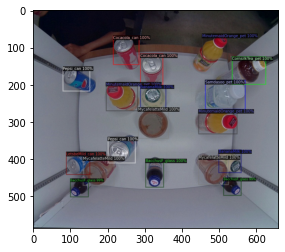

In [5]:
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data.datasets.coco import load_coco_json

import os
import random

model_name = 'faster_rcnn_R_101_FPN_3x'

cfg = get_cfg()
cfg.OUTPUT_DIR = './logs/' + model_name
cfg.merge_from_file(cfg.OUTPUT_DIR + '/config.yaml')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0089999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
cfg.DATASETS.TEST = ("voucher_val", )
predictor = DefaultPredictor(cfg)

root_dir = "/detectron2_repo/datasets/data_voucher_2019"
group_dir = join(root_dir, "group1")
json_file = join(root_dir, group_dir, "annotations_json/instances_val.json")
image_root = join(root_dir, group_dir, "val_images")
    
dataset_dicts = load_coco_json(json_file, image_root)

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    v = Visualizer(im[:, :, ::-1],
                   metadata=voucher_val_metadata, 
                   scale=1.0,
                   instance_mode=ColorMode.SEGMENTATION
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])